Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
# Import resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import gc
import warnings
import seaborn as sns
import xgboost
from pathlib import Path  
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

## Import and Clean Data

The function below runs a python file stored in this repository. For full information, see functions.py

import_and_clean_data() performs the following:
- Reads csv file into dataframe
- Removes unneeded columns from the dataset
- Renames columns with more interpretable labels
- Bins unwieldy variables

Columns were removed for several reasons:
- They are storing metadata about the collection of the dataset
- They were pre-processed for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this analysis
- They represent events that happen after birth has already occurred

In [2]:
# Suppress an unneeded warning
warnings.filterwarnings('ignore')

# Import stored data cleaning function
import functions as fn

df = fn.import_and_clean_data('data/nat2019us.csv')

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
# Confirm dataset was loaded correctly
df.head()

,birth_place,mother_age,mother_native,mother_race,mother_hispanic,marital_status,mother_education,father_age,living_children,deceased_children,...,hepatitis_b,hepatitis_c,steroids,antibiotics,chorioamnionitis,apgar_score,plural_pregnancy,infant_sex,weeks_gestation,down_syndrome
0,hospital,29,Y,native_american,N,married,hs_or_lower,31.0,1.0,0.0,...,N,N,N,N,N,8,1,F,40.0,N
1,hospital,40,N,asian/pi,N,married,college_or_higher,39.0,2.0,0.0,...,N,N,N,N,N,9,1,F,39.0,N
2,hospital,30,Y,native_american,N,married,hs_or_lower,36.0,7.0,0.0,...,N,N,N,Y,N,8,1,M,38.0,N
3,hospital,25,Y,white,N,married,college_or_higher,26.0,1.0,0.0,...,N,N,N,N,N,9,1,M,38.0,N
4,hospital,38,Y,white,N,unmarried,college_or_higher,31.0,1.0,0.0,...,N,N,Y,N,N,9,1,F,37.0,N


In [4]:
# Overview of chosen features
df.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex',
       'weeks_gestation', 'down_syndrome'],
      dtype='object')

## Missing Values

I have chosen to keep as many entries as possible with missing information with the intent of later imputation. In my initial exploratory data analysis I found that entries with missing values tended to be associated with higher rates of unhealthy newborns, which suggests that these entries may have important information for the model to capture. 

In [17]:
# Confirm missing values were marked as NaN for future imputation
df.isna().sum()

birth_place                     62
mother_age                       0
mother_native                 7677
mother_race                      0
mother_hispanic              35104
marital_status              444206
mother_education             53205
father_age                  430117
living_children               5041
deceased_children             7396
terminations                  8340
months_prenatal_care         83396
prenatal_visits              91138
food_assistance              42389
prepregnancy_daily_cig       18529
first_tri_daily_cig          18453
second_tri_daily_cig         18381
third_tri_daily_cig          36979
height                       18795
bmi                              0
delivery_weight              49346
weight_gain                 108997
diabetes                      2383
gestational_diabetes          2383
hypertension                  2383
gestational_hypertension      2383
eclampsia                     2383
previous_premature_birth      2383
infertility_treatmen

## Target Engineering

The Target of the model will be the [5-minute APGAR score](https://www.ncbi.nlm.nih.gov/books/NBK470569/) of the newborn infant, which lies on a scale between 0 and 10. A score between 7 and 10 typically means that the health outlook of the infant is positive, whereas a score between 0 and 6 means the infant will likely require medical intervention. For the purposes of this analysis, I will be filtering the data into these two categories and dropping the small portion of entries with missing APGAR score values.

In [5]:
df['apgar_score'].value_counts()

9     3094327
8      417480
7       77895
10      75873
6       30450
5       16107
99      14673
4        9028
1        7415
3        6507
2        5781
0        2046
Name: apgar_score, dtype: int64

In [6]:
# Bin APGAR score into binary target
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=1, inplace=True)
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=0, inplace=True)

# Drop rows with missing APGAR score
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [7]:
df['apgar_score'].value_counts(normalize=True)

0    0.979339
1    0.020661
Name: apgar_score, dtype: float64

After engineering the target variable, approximately 2% of the newborns in the dataset had a low APGAR score. This is a relatively rare event compared to a high APGAR score, so resampling may be needed to offset this class imbalance.

## Feature Overview

In [8]:
# Define numerical and categorical features
df_cat = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(include=['int64', 'float64'])

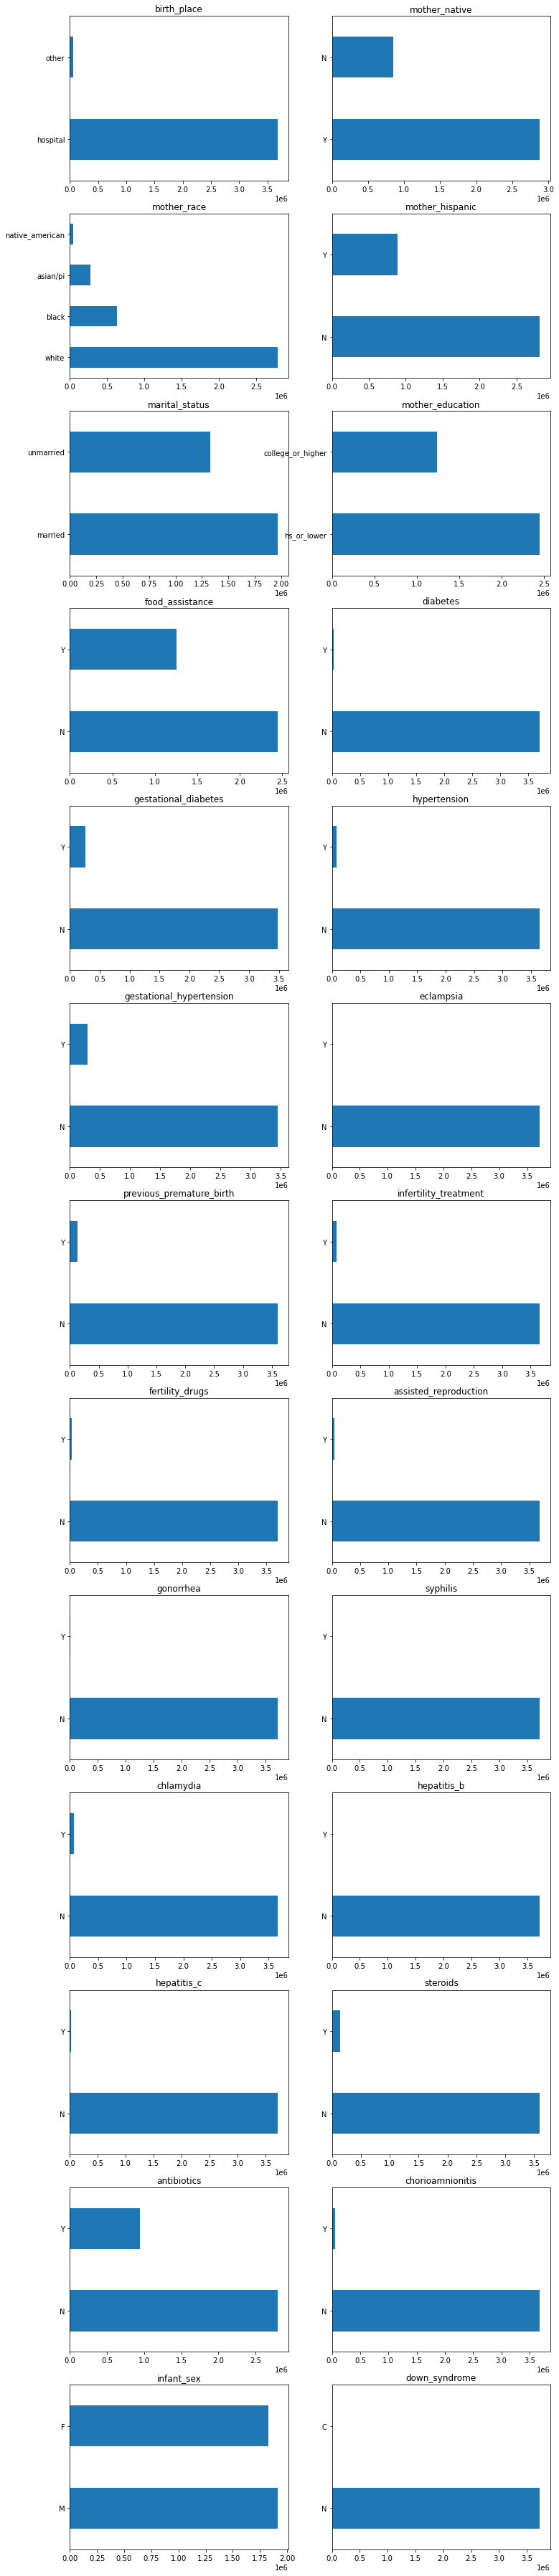

In [9]:
# Distribution of categorical features
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

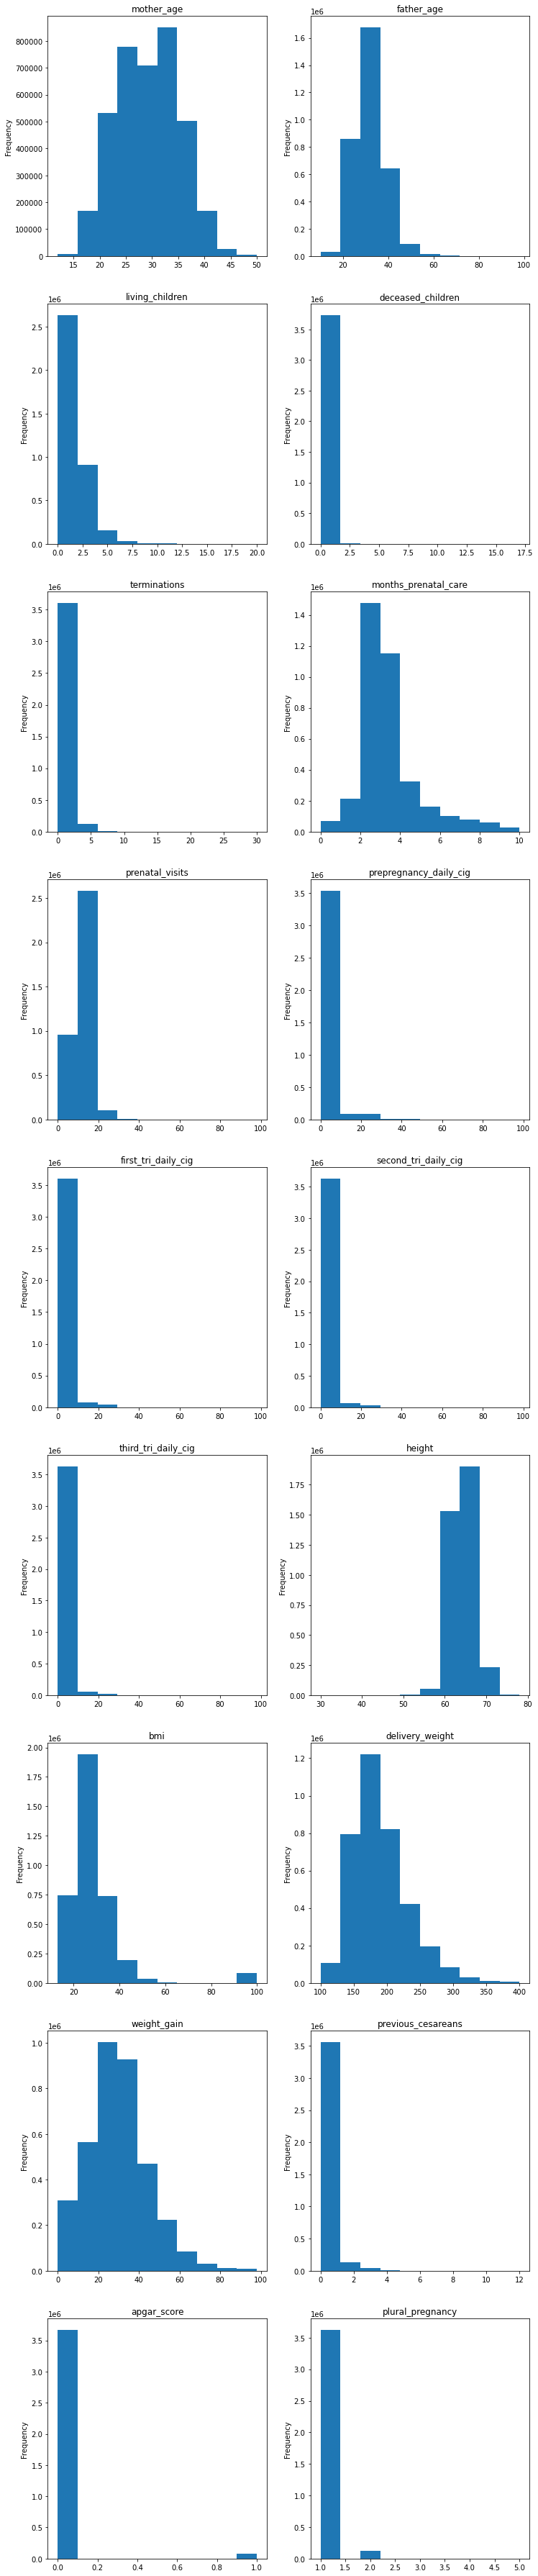

In [10]:
# Distribution of numerical features
fig, axis = plt.subplots(nrows = int((len(df_num.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_num.columns, axis.ravel()):
    df_num[i].plot(kind='hist', ax=subplot, title = i)

ValueError: Grouper for 'apgar_score' not 1-dimensional

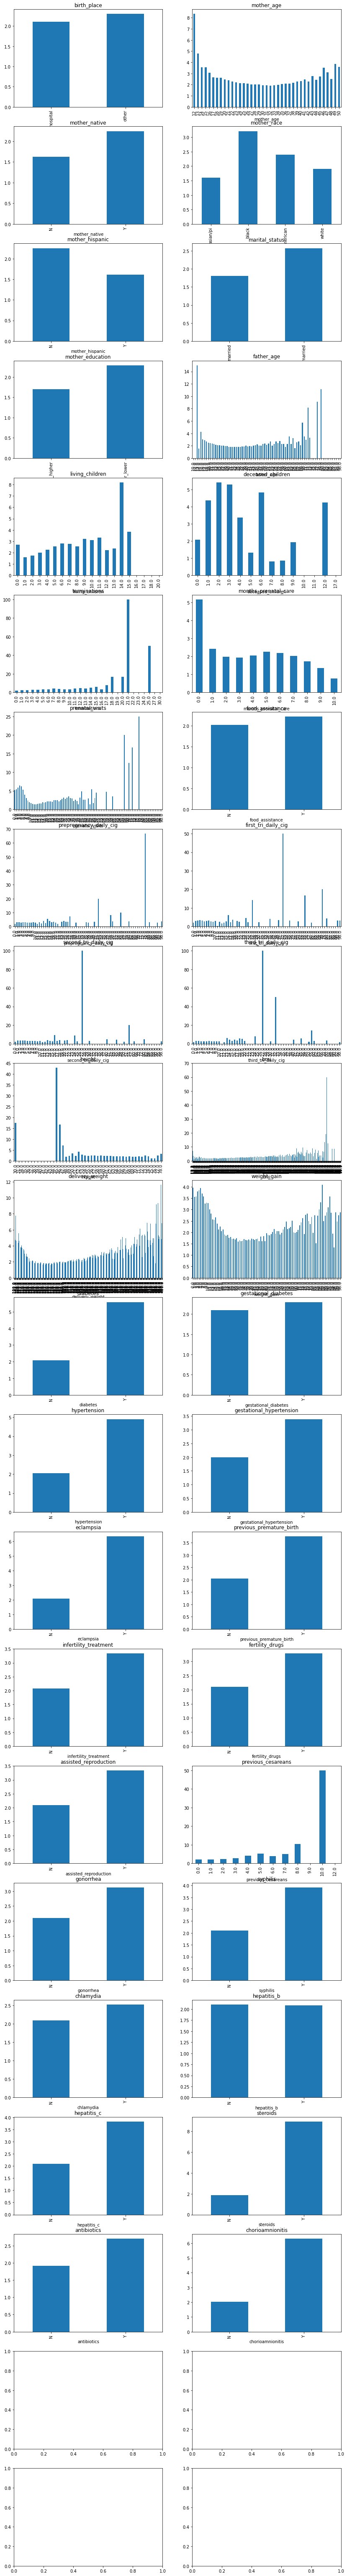

In [16]:
# Plot proportion of each feature to APGAR score
fig, axis = plt.subplots(nrows = int((len(df.columns)/2)), ncols = 2, figsize=(14,len(df.columns)*2.5))

for i, subplot in zip(df.columns, axis.ravel()):
    
    counts = (df[[i, 'apgar_score']]
              .groupby([i, 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

    counts['percent_low_apgar'] = (counts[1]/counts[0])*100
    
    counts['percent_low_apgar'].plot(kind='bar', ax=subplot, title = i)


In [ ]:
# counts = (df[['mother_age', 'apgar_score']]
#               .groupby(['mother_age', 'apgar_score'])
#               .size()
#               .unstack('apgar_score')
#          )

# counts['percent_low_apgar'] = (counts[1]/counts[0])*100

# ax = counts['percent_low_apgar'].plot.bar(color='#ea9999')

## Oversampling

Because the dataset is so massive, it must be sampled into a smaller size due to hardware constraints. This could be rectified in future analysis with cloud computing. However, the dataset's size provides an opportunity to generate a model training dataset without the class imbalance found in the full version. This may reduce performance of the model by causing it to overpredict the minority class in testing, but I believe giving the model more low-APGAR score entries to train on will be worthwhile when misidentifying an emergency case is so costly.

In [18]:
# Create testing set with original target distribution
df_test = df.sample(n=20000, random_state=27, axis=0)
df_test['apgar_score'].value_counts(normalize=True)

0    0.979
1    0.021
Name: apgar_score, dtype: float64

In [20]:
# Remove the rows sampled for the test set so they do not appear in the training set
df_drop = df.drop(df_test.index, axis=0)
df_drop.shape

(3722909, 45)

In [21]:
# Filter dropped dataset by target
df_target1 = df_drop[df_drop['apgar_score'] == 1]
df_target0 = df_drop[df_drop['apgar_score'] == 0]

# Sample an equal number from each target dataframe
df_target1_join = df_target1.sample(n=10000, random_state=27, axis=0)
df_target0_join = df_target0.sample(n=10000, random_state=27, axis=0)

# Merge the two subsampled datasets into training set
df_train = pd.concat([df_target1_join, df_target0_join])
df_train['apgar_score'].value_counts(normalize=True)

1    0.5
0    0.5
Name: apgar_score, dtype: float64

## Train Test Variables

Separate training and testing datasets by feature and target.

In [23]:
X_train = df_train.drop('apgar_score', axis=1)
y_train = df_train['apgar_score']

X_test = df_test.drop('apgar_score', axis=1)
y_test = df_test['apgar_score']

## Free Memory

Because the dataframes are so large, clearing unused variables is necessary to stabilize notebook performance.

In [24]:
del df, df_target1, df_target0, df_target1_join, df_target0_join
gc.collect()

131

## Modeling

### For more information on model testing and optimization, see Grid Search notebook.

Recall will be the primary evaluation metric for this binary classification problem. The cost of mislabeling a positive case (low APGAR score, emergency) as a negative case (high APGAR score, non-emergency) is much higher than the inverse, and recall score is sensitive to the number of false negatives in the model's predictions.

To preprocess the data, several steps are taken depending on the type of feature. For columns with numeric data, the missing values will be imputed with the median of the other entries because median is less affected by outlier values. Then, a min-max scaler is applied to reduce the effect of the differing scales between numeric features by compressing their range between 0 and 1.

For columns with categorical data I applied another simple imputation, this time using "most frequent" as the strategy. The variables are then one-hot encoded for ease of use in modeling.

In future analysis, I could attempt more advanced methods of imputation such as K nearest-neighbor and compare performance.

In [25]:
# Define numeric preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

# Define categorical preprocessing pipeline
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

#Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Dummy Classifier

In order to provide a baseline to compare other models against, I will begin the modeling process using a dummy classifier. This classifier's strategy will be to predict the most frequent target value.

Training Recall Score: 0.0
Test Recall Score: 0.0


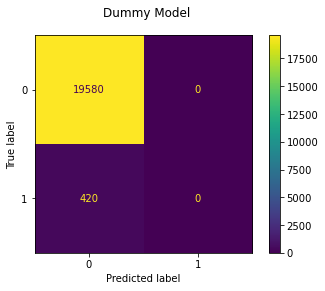

In [32]:
# Define dummy classifier pipeline
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)

# Print recall scores
print("Training Recall Score:", recall_score(y_train, dummy_clf.predict(X_train)))
print("Test Recall Score:", recall_score(y_test, dummy_clf.predict(X_test)))

# Confusion matrix for the dummy model
fig, ax = plt.subplots()
fig.suptitle("Dummy Model")
plot_confusion_matrix(dummy_clf, X_test, y_test, ax=ax, values_format='');

## First Simple Model

For my first simple model, I am using a logistic regression model with close to default parameters. This will serve as a milestone for future model development.

Training Recall Score: 0.5721
Test Recall Score: 0.5761904761904761


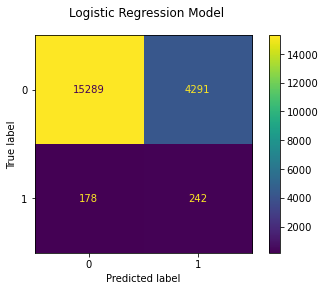

In [38]:
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=27, max_iter=1000))]
)

log_clf.fit(X_train, y_train)

# Print recall scores
print("Training Recall Score:", recall_score(y_train, log_clf.predict(X_train)))
print("Test Recall Score:", recall_score(y_test, log_clf.predict(X_test)))

# Confusion matrix for the dummy model
fig, ax = plt.subplots()
fig.suptitle("Logistic Regression Model")
plot_confusion_matrix(log_clf, X_test, y_test, ax=ax, values_format='');

As mentioned previously, an issue for this classification will be overpredicting the minority class ("1", or low APGAR score) on data with the real distribution of the target variable. Over half of the true emergencies were correctly predicted by the simple model, but further tuning is clearly necessary. 

## Final Model

Training Recall Score: 0.571
Test Recall Score: 0.5761904761904761


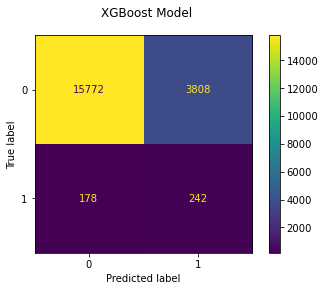

In [36]:
boost = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", xgboost.XGBClassifier(max_depth=2, min_child_weight=2, gamma=1, n_estimators=65, random_state=27))]
)

boost.fit(X_train, y_train)

# Print recall scores
print("Training Recall Score:", recall_score(y_train, boost.predict(X_train)))
print("Test Recall Score:", recall_score(y_test, boost.predict(X_test)))

# Confusion matrix for the dummy model
fig, ax = plt.subplots()
fig.suptitle("XGBoost Model")
plot_confusion_matrix(boost, X_test, y_test, ax=ax, values_format='');

## Saving Train and Test Data 

In [40]:
# filepath1 = Path('data/X_train.csv')  
# filepath1.parent.mkdir(parents=True, exist_ok=True)  
# X_train.to_csv(filepath1)

# filepath2 = Path('data/X_test.csv')  
# filepath2.parent.mkdir(parents=True, exist_ok=True)  
# X_test.to_csv(filepath2)

# filepath3 = Path('data/y_train.csv')  
# filepath3.parent.mkdir(parents=True, exist_ok=True)  
# y_train.to_csv(filepath3)

# filepath4 = Path('data/y_test.csv')  
# filepath4.parent.mkdir(parents=True, exist_ok=True)  
# y_test.to_csv(filepath4)